# Dynamic analysis in zebrafish neural crest development

This tutorial provides a step-by-step workflow for analyzing transcriptional dynamics in our newly sequenced zebrafish Smart-seq3 dataset, focused on neural crest cell development. Leveraging state-of-the-art tools such as `scvelo` [[Bergen *et al*., 2020](https://www.nature.com/articles/s41587-020-0591-3), [La Manno *et al*., 2018](https://www.nature.com/articles/s41586-018-0414-6)] and `cellrank` [[Lange *et al*., 2022](https://www.nature.com/articles/s41592-021-01346-6), [Weiler *et al*., 2024](https://www.nature.com/articles/s41592-024-02303-9), [Reuter *et al*., 2019](https://pubs.aip.org/aip/jcp/article/150/17/174103/198585/Generalized-Markov-modeling-of-nonreversible)], this guide centers on the use of the `regvelo` package to model RNA velocity with gene regulatory priors.

We walk through the complete pipeline, from data preprocessing to model training and transcription factor perturbation analysis. The goal is to uncover key regulators and dynamic processes shaping neural crest development, providing a reproducible framework for applying `regvelo` to similar single-cell transcriptomics studies.

### Library import

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch

import cellrank as cr
import scvi

import mplscience
import matplotlib.pyplot as plt
import seaborn as sns

from regvelo import REGVELOVI
import regvelo as rgv

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [3]:
scv.settings.verbosity = 3
cr.settings.verbosity = 2

In [4]:
%matplotlib inline

In [5]:
plt.rcParams["svg.fonttype"] = "none"
scv.settings.set_figure_params("scvelo", dpi=100, transparent=True, fontsize=14, color_map="viridis")

### Define functions and constants

In [6]:
SIGNIFICANCE_PALETTE = {"n.s.": "#dedede", 
                        "*": "#90BAAD", 
                        "**": "#A1E5AB", 
                        "***": "#ADF6B1"}

In [7]:
from anndata import AnnData
from typing import Sequence

def visits_diff_perTF(adata: AnnData, 
                      terminal_state: str | Sequence[str], 
                      dd_sig: np.ndarray, 
                      sig_palette: dict) -> list[pd.DataFrame, list[str]]:

    data = []
    palette_rel = []
    
    for i in range(len(TERMINAL_STATES)):
        ts = TERMINAL_STATES[i]
        p_value = dd_sig[i]
        terminal_indices_sub = np.where(adata.obs["term_states_fwd"].isin([ts]))[0]
    
        values = adata.obs["visits_diff"].iloc[terminal_indices_sub]
        subgroups = [ts]*len(values)
    
        for val, subgrp in zip(values, subgroups):
            data.append({"Value": val, "Group": subgrp})
    
        significance = rgv.mt.get_significance(p_value)
        print(f"{ts}: {p_value}")
        palette_rel.append(SIGNIFICANCE_PALETTE[significance])
    
    return pd.DataFrame(data), palette_rel

def plot_visits_dist(df: pd.DataFrame, palette_rel: list[str], tick_range: float) -> None:
    with mplscience.style_context():
        sns.set_style("whitegrid")
        fig, ax = plt.subplots(figsize=(3, 3))
        
        sns.boxplot(
            data=df,
            y="Group",
            x="Value",
            palette=palette_rel,
            ax=ax,
            flierprops={
                'marker': '.',
                'markersize': 5,
                'markerfacecolor': 'black',
                'markeredgecolor': 'black'
            }
        )
        ax.set_xlabel("Density change likelihood")
        ax.set_ylabel("Terminal state")
    
        tick_range = tick_range
        tick_step = tick_range
        xmin, xmax = 0.5 - tick_range, 0.5 + tick_range
    
        ticks = np.arange(xmin, xmax + 1e-6, tick_step)
        if 0.5 not in ticks:
            ticks = np.sort(np.append(ticks, 0.5))
        
        ax.set_xlim(xmin, xmax)
        ax.set_xticks(ticks)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
    
        plt.show()

### Load data

In [8]:
adata = rgv.datasets.zebrafish_nc()
prior_net = rgv.datasets.zebrafish_grn()
TF_list = adata.var_names[adata.var["is_tf"]].tolist()

In [9]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
scv.pp.moments(adata)

2025-07-01 10:45:12.520261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751359512.628946 3080656 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751359512.672947 3080656 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751359513.058983 3080656 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751359513.058999 3080656 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751359513.059002 3080656 computation_placer.cc:177] computation placer alr

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


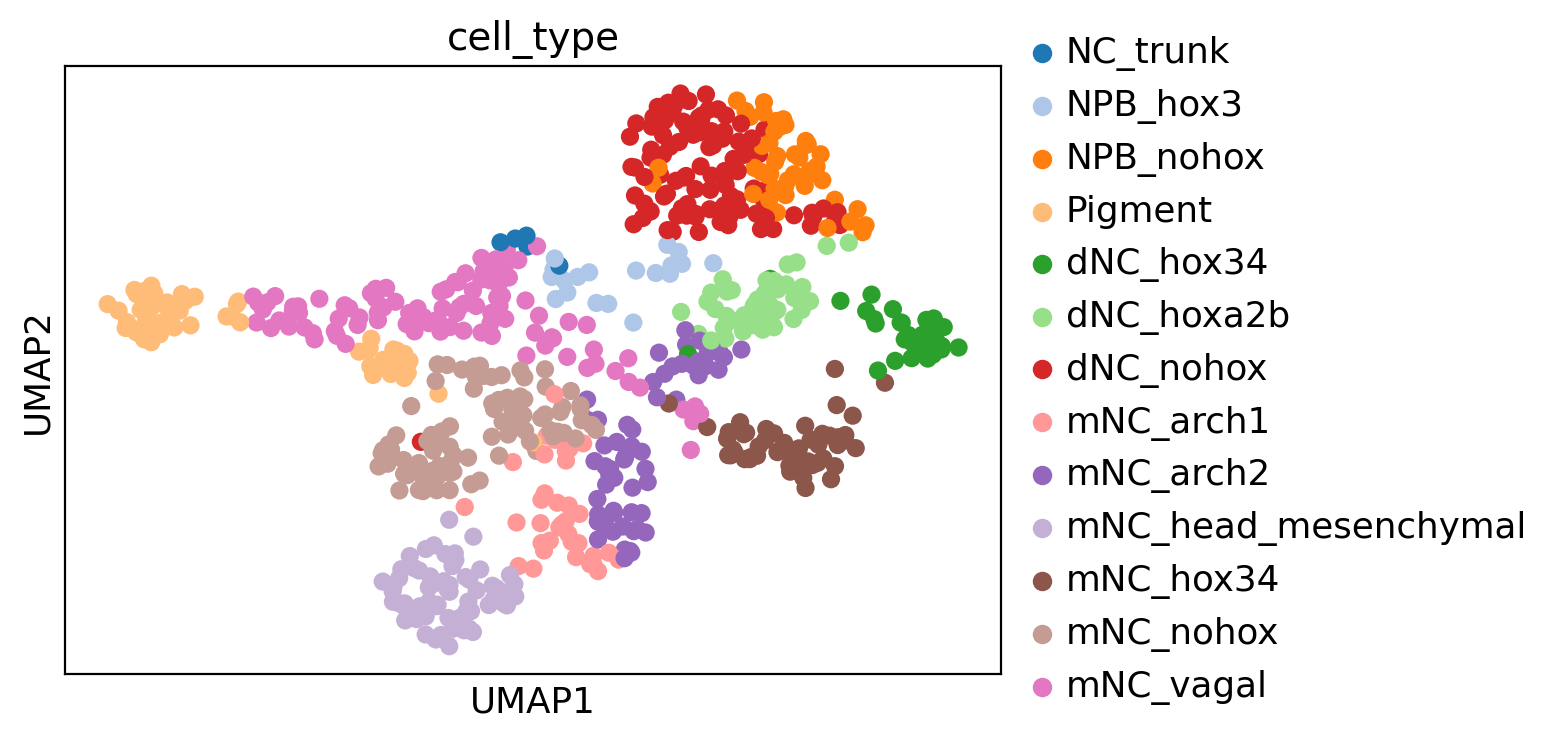

In [10]:
sc.pl.umap(adata, color='cell_type', palette=sc.pl.palettes.vega_20)

### Preprocessing

In [11]:
adata = rgv.pp.preprocess_data(adata)
adata = rgv.pp.set_prior_grn(adata, prior_net.T)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [12]:
TF_list = set(TF_list).intersection(adata.var_names)
TF_list = list(TF_list)
print("final number of TFs: " + str(len(TF_list)))

final number of TFs: 81


In [13]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W))

In [14]:
sparsity = W.sum() / ((W.sum(1) != 0).sum() * W.shape[0])
print("network sparsity: " + str(np.array(sparsity)))

network sparsity: 0.052775327


## Train RegVelo model

In [15]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata, W=W.T, regulators=TF_list, soft_constraint=False)

In [16]:
reg_vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packag

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2377.829. Signaling Trainer to stop.


In [17]:
adata = reg_vae.add_regvelo_outputs_to_adata(adata=adata)
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/128 cores)


  0%|          | 0/697 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Predict terminal states

Computing transition matrix using `'deterministic'` model


  0%|          | 0/697 [00:00<?, ?cell/s]

Using `softmax_scale=9.5760`


  0%|          | 0/697 [00:00<?, ?cell/s]

    Finish (0:00:07)
Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:07)
Computing `7` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing fate probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


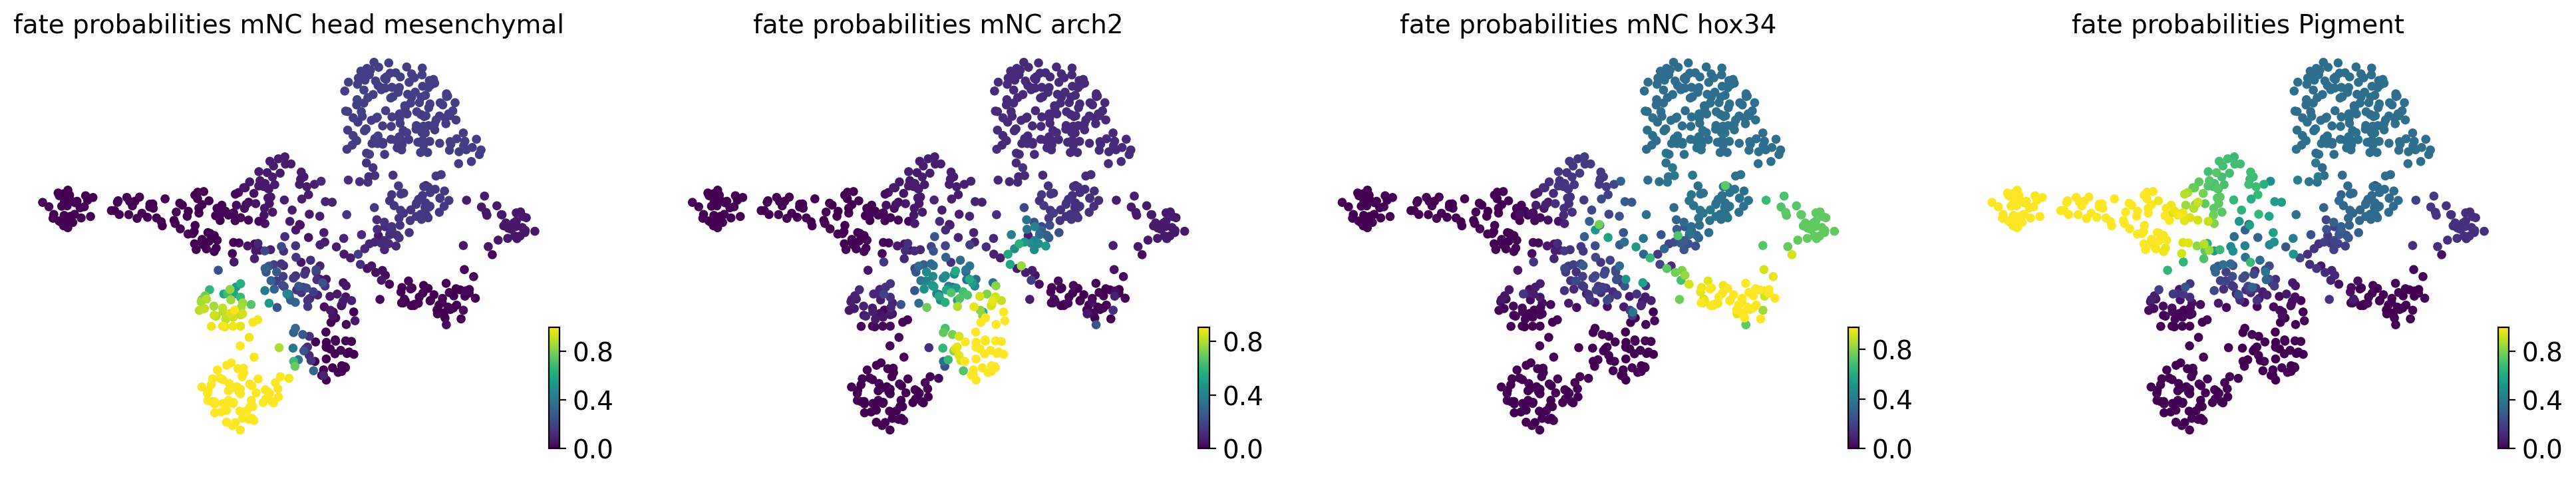

In [18]:
TERMINAL_STATES = ["mNC_head_mesenchymal",
                  "mNC_arch2",
                  "mNC_hox34",
                  "Pigment"]
vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
estimator = cr.estimators.GPCCA(vk)

## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=7, cluster_key="cell_type")
estimator.set_terminal_states(TERMINAL_STATES)
estimator.compute_fate_probabilities()
estimator.plot_fate_probabilities(same_plot=False)

/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord -

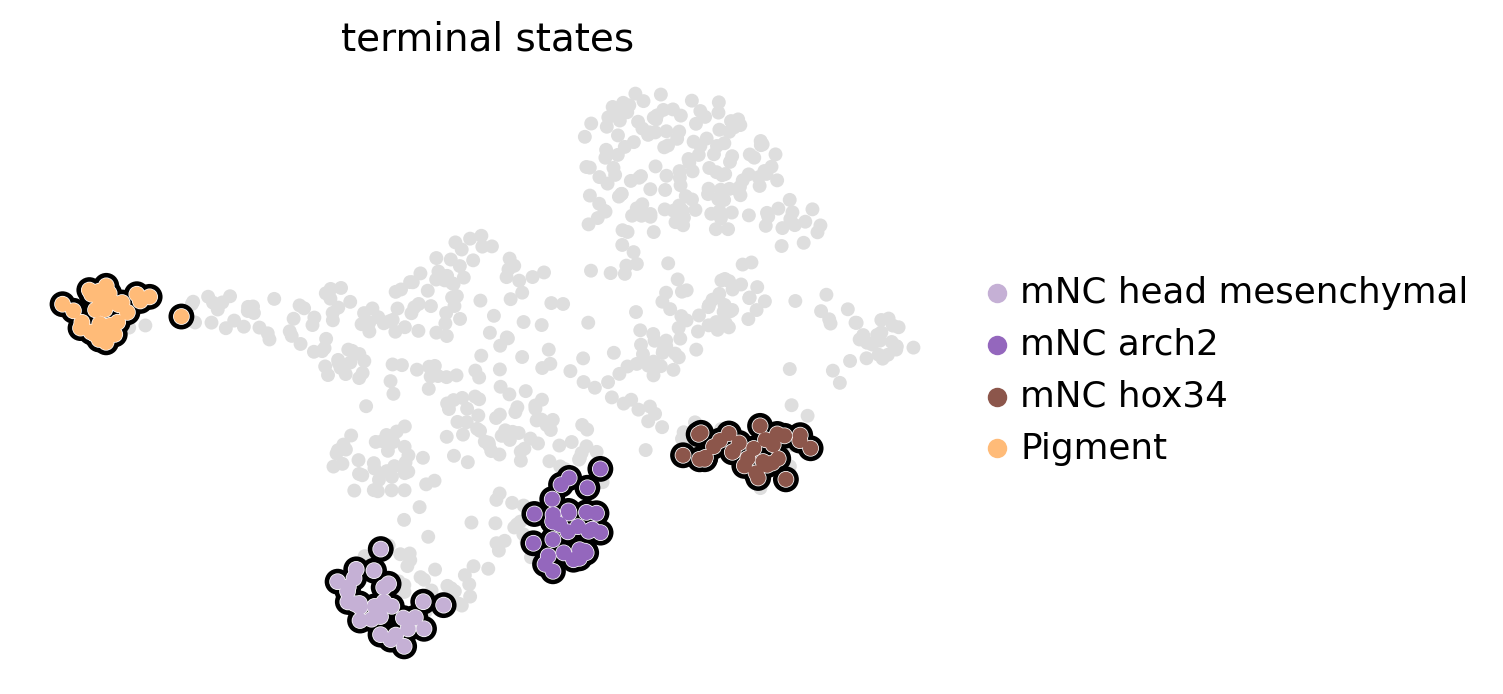

In [19]:
estimator.plot_macrostates(which="terminal", legend_loc="right", s=100)

### Save model

In [20]:
reg_vae.save("rgv_model")

## Perform perturbation screening

In the perturbation screening step, RegVelo enables users to generate a perturbed vector field matrix, which is stored in `adata_target_perturb.layers["velocity"]`. This is then used to construct a new [CellRank](https://www.nature.com/articles/s41592-021-01346-6) kernel, which results in an updated estimate of perturbed cell fate prpobabilities.

We evalute the perturbation effects using two approaches:
<br>
(a) by comparing cell fate probabilities before and after perturbation, and 
<br>
(b) by simulating cell transitions using a Markov chain based on transition matrices inferred from the velocity fields of the unperturbed and perturbed systems.

Let $m$ denote the number of terminal states and $N_C$ the number of cells. For approach (a), we define the *depletion likelihood* to a terminal state $k$ as the normalized Mann-Whitney $U$ statistic 

\begin{equation}
l_d = \frac{1}{N_c^2} \sum_{n=1}^{N_C} \sum_{n^*=1}^{N_C} \mathbb{I} (\Pi_{:,k}(n) > \Pi_{:,k}^*(n^*)),
\end{equation}

where $\mathbb{I}$ is the indicator function and $\Pi, \ \Pi^* \in \mathbb{R}^{N_c \times m}$ are the control and perturbed cell fate probability matrices, respectively. 
For a terminal state $k$, a depletion likelihood $l_d > 0.5$ indicates a long-term depletion effect in the perturbed system, as illustrated in Figure 1 (a). 

It is important to note that the depletion likelihood depends on the long-term fate probabilities of transient cells. In particular, a reduction in a transient cell’s probability of reaching one terminal state must be balanced by an increase in its probability of reaching other terminal states, since the row-wise sums of $\Pi$ and $\Pi^*$ are approximately 1. This redistribution can thus lead to possible long-term enrichment effects in terminal states.

To capture short-term dynamics of the perturbed system, we also simulate the development of progenitor cells over a finite number of steps (``n_steps``) using Markov chain derived from the velocity-based transition matrices of both control and perturbed systems using the function ``rgv.tl.markov_density_simulation``. We then compare the frequency with which terminal cells are reached in both cases, quantifying depletion effects in short-term dynamics (Figure 1(b)). 

The Markov chain simulations can be run with either ``method='stepwise'`` (default) or ``method='one-step'``. The stepwise method simulates transitions one step at a time and terminates each trajectory either upon reaching a terminal cell or after ``n_steps``, whichever comes first. In contrast, the one-step method computes the cell state distribution after ``n_steps`` and draws samples directly from this distribution, without modeling intermediate transitions.

```{figure} _static/perturbation_metrics.svg
:width: 300
:name: fig-perturbation-effects
```

**Figure 1:** Visualization of perturbation effects.  
(a) Depletion likelihood $l_d$ where $\bar{\Pi}_{.k}$ and $\bar{\Pi}^*_{.k}$ denote mean cell fate probabilities.  
(b) Simulated Markov chain transitions of progenitor cells.

In the following, we demonstrate both perturbation quantification approaches for two perturbed models, in which we remove the transcription factors *nr2f5* and *elf1*, respectively.

Terminal states for the perturbed dynamics can be defined in two ways: Either by explicitly setting them via ``estimator.set_terminal_states(TERMINAL_STATES)``, or by reusing the terminal state indices identified in the original dynamics using [CellRank](https://www.nature.com/articles/s41592-021-01346-6).

### Calculating depletion likelihood based on cell fate probability

In [21]:
adata_perturb_dict = {}
cand_list = ["nr2f5", "elf1"]

for TF in cand_list:
    model = 'rgv_model'
    adata_target_perturb, reg_vae_perturb =  rgv.tl.in_silico_block_simulation(model=model,
                                                                               adata=adata,
                                                                               TF=TF,
                                                                               cutoff=0)
    adata_perturb_dict[TF] = adata_target_perturb

INFO     File rgv_model/model.pt already downloaded                                                                
INFO     File rgv_model/model.pt already downloaded                                                                


In [22]:
ct_indices = {
    ct: adata.obs["term_states_fwd"][adata.obs["term_states_fwd"] == ct].index.tolist()
    for ct in TERMINAL_STATES}

# Computing states transition probability for perturbed systems
for TF, adata_target_perturb in adata_perturb_dict.items():
    vkp = cr.kernels.VelocityKernel(adata_target_perturb).compute_transition_matrix()
    estimator = cr.estimators.GPCCA(vkp)
    estimator.compute_macrostates(n_states=7, cluster_key='cell_type')
    estimator.set_terminal_states(ct_indices)
    estimator.compute_fate_probabilities()

    adata_perturb_dict[TF] = adata_target_perturb

Computing transition matrix using `'deterministic'` model


  0%|          | 0/697 [00:00<?, ?cell/s]

Using `softmax_scale=9.9602`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

    Finish (0:00:00)
Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `7` macrostates


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing fate probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)
Computing transition matrix using `'deterministic'` model


  0%|          | 0/697 [00:00<?, ?cell/s]

Using `softmax_scale=9.6380`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

    Finish (0:00:00)
Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `7` macrostates


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing fate probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


In [23]:
df = rgv.mt.cellfate_perturbation(perturbed=adata_perturb_dict, baseline=adata, terminal_state=TERMINAL_STATES)
df

,Depletion likelihood,p-value,FDR adjusted p-value,Terminal state,TF
0,0.570827,0.000002,0.000009,mNC_head_mesenchymal,nr2f5
1,0.468141,0.980279,0.995731,mNC_arch2,nr2f5
2,0.459316,0.995731,0.995731,mNC_hox34,nr2f5
3,0.478670,0.916038,0.995731,Pigment,nr2f5
0,0.470181,0.973052,0.993760,mNC_head_mesenchymal,elf1
1,0.461354,0.993760,0.993760,mNC_arch2,elf1
2,0.467785,0.981355,0.993760,mNC_hox34,elf1
3,0.546538,0.001313,0.005252,Pigment,elf1


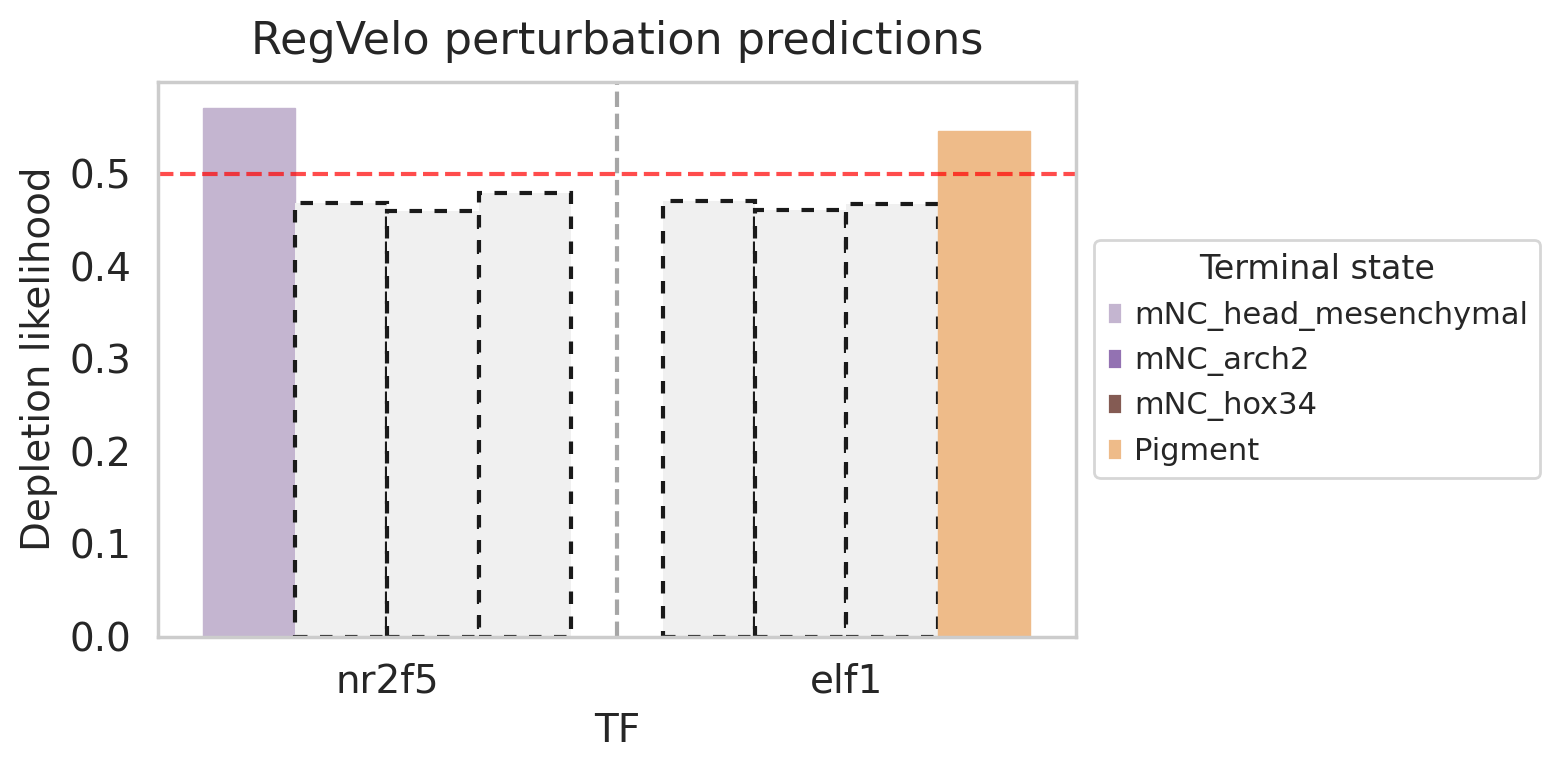

In [24]:
rgv.pl.cellfate_perturbation(adata=adata,
                             df=df,
                             fontsize=14,
                             figsize=(8, 4),
                             legend_loc='center left',
                             legend_bbox=(1.02, 0.5),
                             color_label="cell_type")

By removing the TF *nr2f5*, one would expect a depletion of the cell type *mNC_head_mesenchymal* and an enrichment of the cell types *mNC_arch2*, *mNC_hox34*, and *Pigment* in the long run, compared to the control dynamics.

By removing the TF *elf1*, one would expect a depletion of the cell type *Pigment* and an enrichment of the cell types *mNC_head_mesenchymal*, *mNC_arch2*, and *mNC_hox34* in the long run, compared to the control dynamics.

For both models, we now have a look at their short-term perturbation effects and demonstrate both ``stepwise``and ``one-step`` methods. Transition matrices are computed using [CellRank](https://www.nature.com/articles/s41592-021-01346-6) on the original and perturbed velocity fields.

### Calculating density change likelihood based on stochastic simulations
For the Markov chain simulations, we note that the choice of ``n_steps`` in `rgv.tl.markov_density_simulation` can be made by evaluating the proportion of processes ending in a terminal cell using the control (unperturbed) cell state transition matrix. In this tutorial, we will use the default value ``n_steps=100``.

The function additionally takes as input ``n_simulations``, which determines the number of simulations to be performed for each cell. In this notebook, we will use the default value `n_simulations=1000`.

For the initial state, we select cells of type *NPB_nohox* and determine the `start_indices` and `terminal_indices`, which are required as input for the `rgv.tl.markov_density_simulation` function.

To compare the number of times each terminal cell is visited in the perturbed versus the control model, we compute the difference:
\begin{equation}
\# \text{visits in perturbed model} - \# \text{visits in control model}.
\end{equation}

The absolute and relative number of visits to each terminal cell are stored in `.obs["visits"]` and `.obs["visits_dens"]`, respectively.

For each terminal state, we then use the function `rgv.tl.simulated_density_diff` to compute the average difference in visit counts between the perturbed and unperturbed systems. This function also performs a paired t-test (`scipy.stats.ttest_rel`) to assess whether the number of visits differ significantly between the two systems. The resulting p-values are returned as output.

To visualize short-term perturbation effects, we use the function `rgv.pl.simulated_density_diff`. For each terminal cell, the function computes the difference in the number of visits between the perturbed and control simulations. To account for stochastic variability across simulations, this difference is scaled by $1/\sqrt{\text{\# total simulations}}$. The resulting scaled differences are then passed through a sigmoid function and stored in `adata.obs['visits_diff']`. These scores are further smoothed over neighboring cells to produce a spatially coherent signal, stored in `adata.obs['visits_diff_smoothed']`. Values below 0.5 indicate a relative depletion of visits to the corresponding terminal cell under perturbation.

In [25]:
vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
vkt = vk.transition_matrix.A
terminal_indices = np.where(adata.obs["term_states_fwd"].isin(TERMINAL_STATES))[0]
start_indices = np.where(adata.obs["cell_type"].isin(["NPB_nohox"]))[0]

Computing transition matrix using `'deterministic'` model


  0%|          | 0/697 [00:00<?, ?cell/s]

Using `softmax_scale=9.5760`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


#### Method 1: Stepwise simulations - *nr2f5* perturbation
We first consider the perturbed model by removing the TF *nr2f5*.

In [26]:
method = "stepwise"

TF = "nr2f5"
adata_perturb = adata_perturb_dict[TF].copy()
adata_perturb.obs["cell_type"] = adata.obs["cell_type"].copy()

vk_p = cr.kernels.VelocityKernel(adata_perturb).compute_transition_matrix()
vkt_p = vk_p.transition_matrix.A

Computing transition matrix using `'deterministic'` model


  0%|          | 0/697 [00:00<?, ?cell/s]

Using `softmax_scale=9.9602`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


In [27]:
total_simulations = rgv.tl.markov_density_simulation(adata, 
                                                     vkt, 
                                                     start_indices, 
                                                     terminal_indices, 
                                                     TERMINAL_STATES,
                                                     method=method)

_ = rgv.tl.markov_density_simulation(adata_perturb, 
                                     vkt_p, 
                                     start_indices, 
                                     terminal_indices, 
                                     TERMINAL_STATES,
                                     method=method)

In [28]:
dd_score, dd_sig = rgv.tl.simulated_visit_diff(adata, adata_perturb, TERMINAL_STATES)
print(dd_score)
print(dd_sig)

[-79.1, -24.5, -41.400000000000006, -88.29999999999998]
[1.0388254084002412e-07, 6.385268221500673e-07, 6.971348452267312e-10, 0.0004889179271363851]


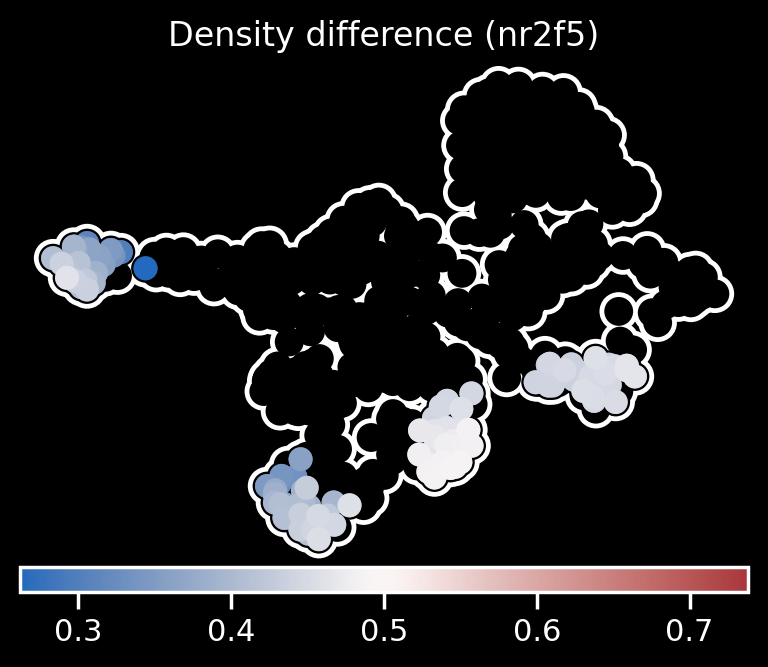

In [29]:
rgv.pl.simulated_visit_diff(adata, 
                            adata_perturb, 
                            TERMINAL_STATES, 
                            total_simulations,
                            title="Density difference (nr2f5)")

We also visualize the distribution of `adata.obs['visits_diff']` for each terminal state using a boxplot. The values are grouped by terminal state and colored according to the p-value from the paired t-test comparing visit counts between the unperturbed and perturbed systems.

In [30]:
df, palette_rel = visits_diff_perTF(adata, TERMINAL_STATES, dd_sig, SIGNIFICANCE_PALETTE)

mNC_head_mesenchymal: 1.0388254084002412e-07
mNC_arch2: 6.385268221500673e-07
mNC_hox34: 6.971348452267312e-10
Pigment: 0.0004889179271363851


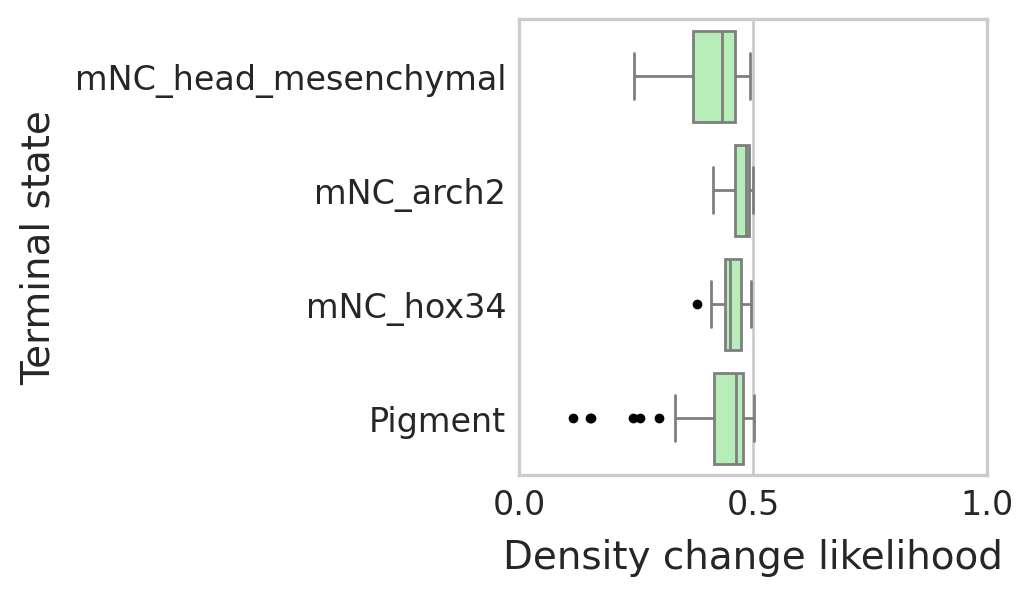

In [31]:
plot_visits_dist(df, palette_rel, 0.5)

#### Method 1: Stepwise simulations - *elf1* perturbation
We now consider the perturbed model by removing the TF *elf1*. 

In [32]:
del adata.obs['visits']
del adata.obs['visits_dens']
del adata.obs['visits_diff']
del adata.obs['visits_diff_smooth']

In [33]:
TF = "elf1"
adata_perturb = adata_perturb_dict[TF].copy()
adata_perturb.obs["cell_type"] = adata.obs["cell_type"].copy()

vk_p = cr.kernels.VelocityKernel(adata_perturb).compute_transition_matrix()
vkt_p = vk_p.transition_matrix.A

Computing transition matrix using `'deterministic'` model


  0%|          | 0/697 [00:00<?, ?cell/s]

Using `softmax_scale=9.6380`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


In [34]:
total_simulations = rgv.tl.markov_density_simulation(adata, 
                                                     vkt, 
                                                     start_indices, 
                                                     terminal_indices, 
                                                     TERMINAL_STATES,
                                                     method=method)

_ = rgv.tl.markov_density_simulation(adata_perturb, 
                                     vkt_p, 
                                     start_indices, 
                                     terminal_indices, 
                                     TERMINAL_STATES,
                                     method=method)

In [35]:
dd_score, dd_sig = rgv.tl.simulated_visit_diff(adata, adata_perturb, TERMINAL_STATES)
print(dd_score)
print(dd_sig)

[4.900000000000006, 7.099999999999994, 5.36666666666666, -22.0]
[0.002008393908970593, 0.0008743624255374171, 0.004047887217802147, 0.013239451053673714]


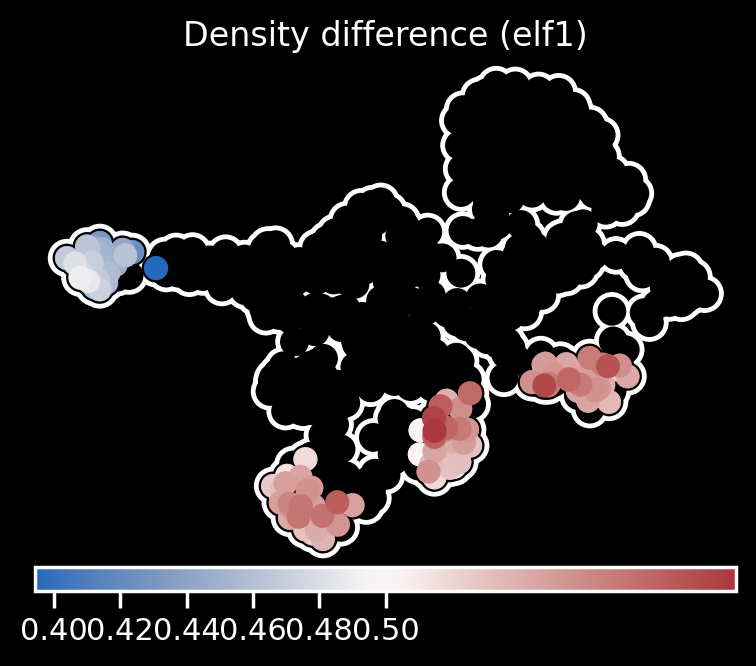

In [36]:
rgv.pl.simulated_visit_diff(adata, 
                            adata_perturb, 
                            TERMINAL_STATES, 
                            total_simulations,
                            title="Density difference (elf1)")

In [37]:
df, palette_rel = visits_diff_perTF(adata, TERMINAL_STATES, dd_sig, SIGNIFICANCE_PALETTE)

mNC_head_mesenchymal: 0.002008393908970593
mNC_arch2: 0.0008743624255374171
mNC_hox34: 0.004047887217802147
Pigment: 0.013239451053673714


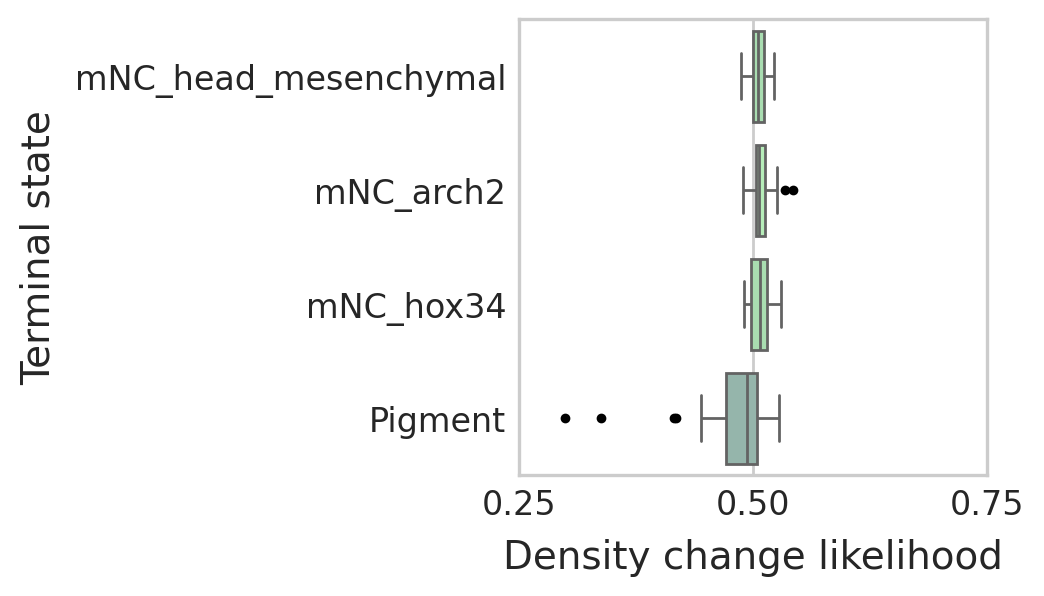

In [38]:
plot_visits_dist(df, palette_rel, 0.25)

#### Method 2: One-step simulations - *nr2f5* perturbation

In [39]:
del adata.obs['visits']
del adata.obs['visits_dens']
del adata.obs['visits_diff']
del adata.obs['visits_diff_smooth']

In [40]:
method = "one-step"

TF = "nr2f5"
adata_perturb = adata_perturb_dict[TF].copy()
adata_perturb.obs["cell_type"] = adata.obs["cell_type"].copy()

vk_p = cr.kernels.VelocityKernel(adata_perturb).compute_transition_matrix()
vkt_p = vk_p.transition_matrix.A

Computing transition matrix using `'deterministic'` model


  0%|          | 0/697 [00:00<?, ?cell/s]

Using `softmax_scale=9.9602`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


In [41]:
total_simulations = rgv.tl.markov_density_simulation(adata, 
                                                     vkt, 
                                                     start_indices, 
                                                     terminal_indices, 
                                                     TERMINAL_STATES,
                                                     method=method)

_ = rgv.tl.markov_density_simulation(adata_perturb, 
                                     vkt_p, 
                                     start_indices, 
                                     terminal_indices, 
                                     TERMINAL_STATES,
                                     method=method)

In [42]:
dd_score, dd_sig = rgv.tl.simulated_visit_diff(adata, adata_perturb, TERMINAL_STATES)
print(dd_score)
print(dd_sig)

[-95.23333333333332, -4.600000000000001, -17.433333333333337, -95.46666666666667]
[1.8341934745831434e-05, 0.006290120629851753, 3.731241368483117e-08, 2.9413421676244866e-09]


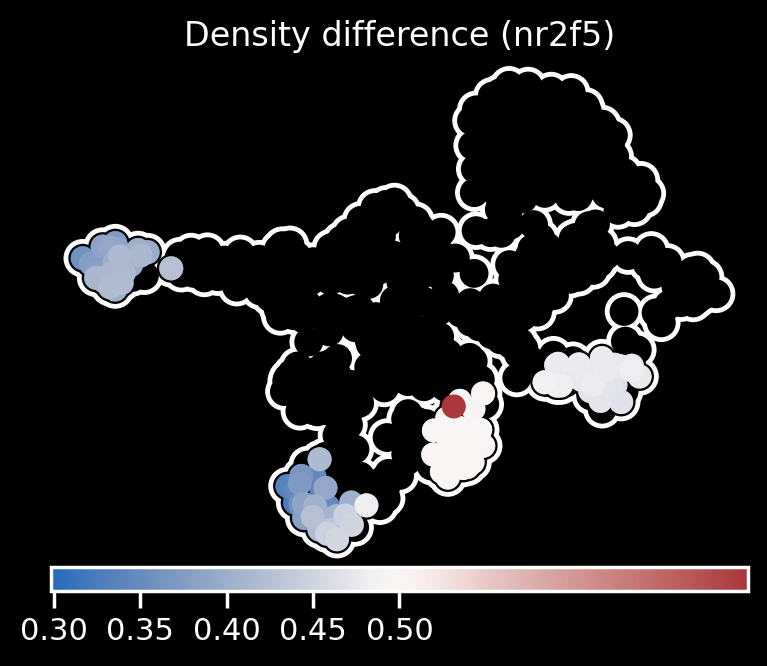

In [43]:
rgv.pl.simulated_visit_diff(adata, 
                            adata_perturb, 
                            TERMINAL_STATES, 
                            total_simulations,
                            title="Density difference (nr2f5)")

In [44]:
df, palette_rel = visits_diff_perTF(adata, TERMINAL_STATES, dd_sig, SIGNIFICANCE_PALETTE)

mNC_head_mesenchymal: 1.8341934745831434e-05
mNC_arch2: 0.006290120629851753
mNC_hox34: 3.731241368483117e-08
Pigment: 2.9413421676244866e-09


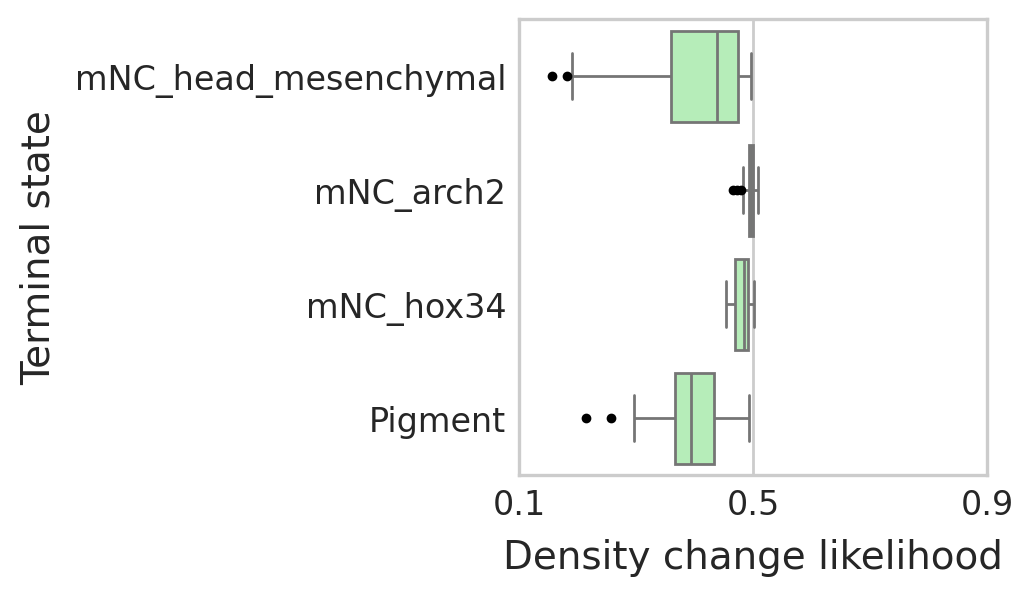

In [45]:
plot_visits_dist(df, palette_rel, 0.4)

#### Method 2: One-step simulations - *elf1* perturbation

In [46]:
del adata.obs['visits']
del adata.obs['visits_dens']
del adata.obs['visits_diff']
del adata.obs['visits_diff_smooth']

In [47]:
TF = "elf1"
adata_perturb = adata_perturb_dict[TF].copy()
adata_perturb.obs["cell_type"] = adata.obs["cell_type"].copy()

vk_p = cr.kernels.VelocityKernel(adata_perturb).compute_transition_matrix()
vkt_p = vk_p.transition_matrix.A

Computing transition matrix using `'deterministic'` model


  0%|          | 0/697 [00:00<?, ?cell/s]

Using `softmax_scale=9.6380`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


In [48]:
total_simulations = rgv.tl.markov_density_simulation(adata, 
                                                     vkt, 
                                                     start_indices, 
                                                     terminal_indices, 
                                                     TERMINAL_STATES,
                                                     method=method)

_ = rgv.tl.markov_density_simulation(adata_perturb, 
                                     vkt_p, 
                                     start_indices, 
                                     terminal_indices, 
                                     TERMINAL_STATES,
                                     method=method)

In [49]:
dd_score, dd_sig = rgv.tl.simulated_visit_diff(adata, adata_perturb, TERMINAL_STATES)
print(dd_score)
print(dd_sig)

[11.166666666666686, 1.8000000000000007, 4.0, -25.366666666666674]
[0.002911826078296765, 0.3150595410541873, 0.04884985995147162, 1.3704022023195775e-05]


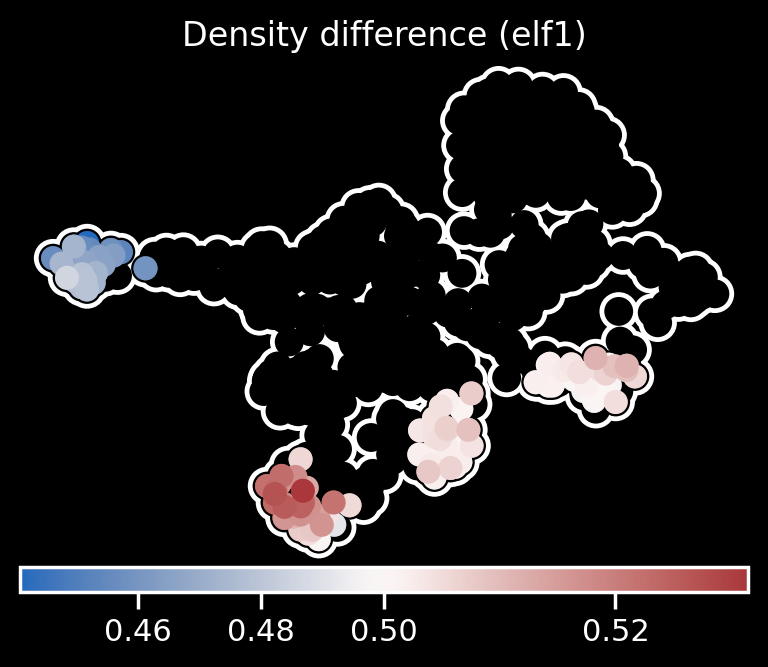

In [50]:
rgv.pl.simulated_visit_diff(adata, 
                            adata_perturb, 
                            TERMINAL_STATES, 
                            total_simulations,
                            title="Density difference (elf1)")

In [51]:
df, palette_rel = visits_diff_perTF(adata, TERMINAL_STATES, dd_sig, SIGNIFICANCE_PALETTE)

mNC_head_mesenchymal: 0.002911826078296765
mNC_arch2: 0.3150595410541873
mNC_hox34: 0.04884985995147162
Pigment: 1.3704022023195775e-05


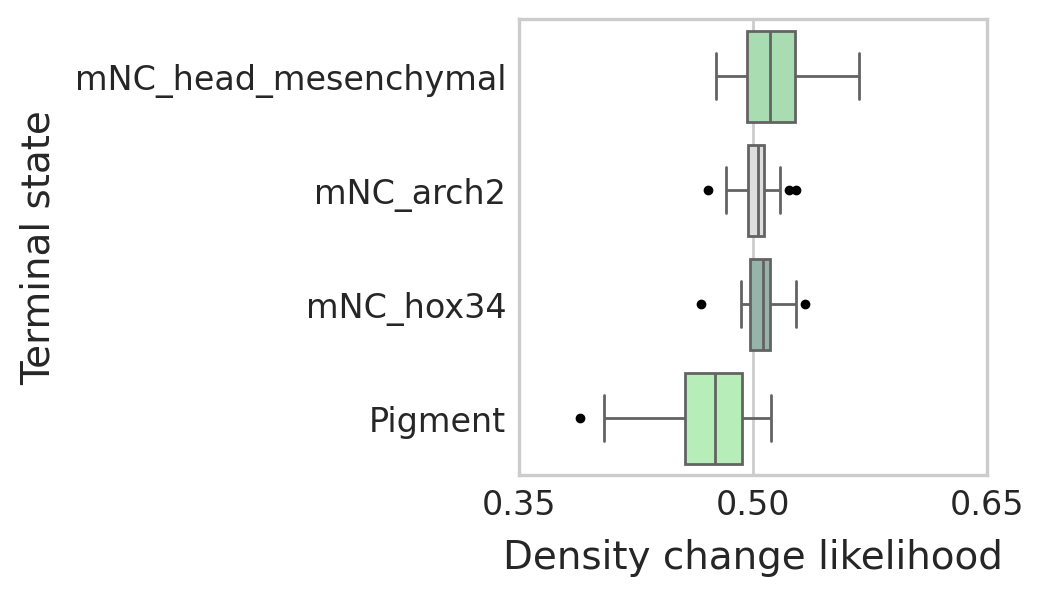

In [52]:
plot_visits_dist(df, palette_rel, 0.15)

## Screening different KO combination

After completing the steps above, users can perform end-to-end computations using the `rgv.tl.TFscreening` function. This function allows users to set parameters such as `n_states`. Additionally, setting the `n_repeats` argument (e.g., `n_repeats=5`) enables the model to run multiple times, aggregating perturbation results across runs to improve the robustness and stability of the estimates. By default, the model is run only once.

In [53]:
KO_list = ["nr2f5", "elf1"]

perturb_likelihood, perturb_pval = rgv.tl.TFscreening(adata=adata,
                                                      prior_graph=W.T,
                                                      soft_constraint=False,
                                                      TF_list=TF,
                                                      cluster_label="cell_type",
                                                      terminal_states=TERMINAL_STATES,
                                                      KO_list=KO_list,
                                                      n_states=8,
                                                      cutoff=0)

training model...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_co

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2400.929. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/groups/ml01/workspace/yifan.chen/regvelo_reproducibility/notebooks/tutorials/zebrafish/perturb_r
         epeat_runs/rgv_model_0/model.pt already downloaded                                                        
Computing transition matrix using `'deterministic'` model


  0%|          | 0/697 [00:00<?, ?cell/s]

Using `softmax_scale=9.3675`


  0%|          | 0/697 [00:00<?, ?cell/s]

    Finish (0:00:01)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing fate probabilities
Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)
INFO     File                                                                                                      
         /icts

  0%|          | 0/697 [00:00<?, ?cell/s]

Using `softmax_scale=9.6567`


  0%|          | 0/697 [00:00<?, ?cell/s]

    Finish (0:00:00)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing fate probabilities
Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)
Done nr2f5
INFO     File                                                                                                      
   

  0%|          | 0/697 [00:00<?, ?cell/s]

Using `softmax_scale=9.4436`


  0%|          | 0/697 [00:00<?, ?cell/s]

    Finish (0:00:00)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing fate probabilities
Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)
Done elf1


In [54]:
perturb_likelihood

,mNC_head_mesenchymal,mNC_arch2,mNC_hox34,Pigment
elf1,0.472146,0.460774,0.481982,0.542228
nr2f5,0.562124,0.465541,0.462124,0.470878
